# KNN 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import os
import math
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# making results reproducible
np.random.seed(42)

In [2]:
#Read datasets
df = pd.read_csv('data.csv',index_col=0)  
df = df.iloc[: , 0:]

<AxesSubplot:>

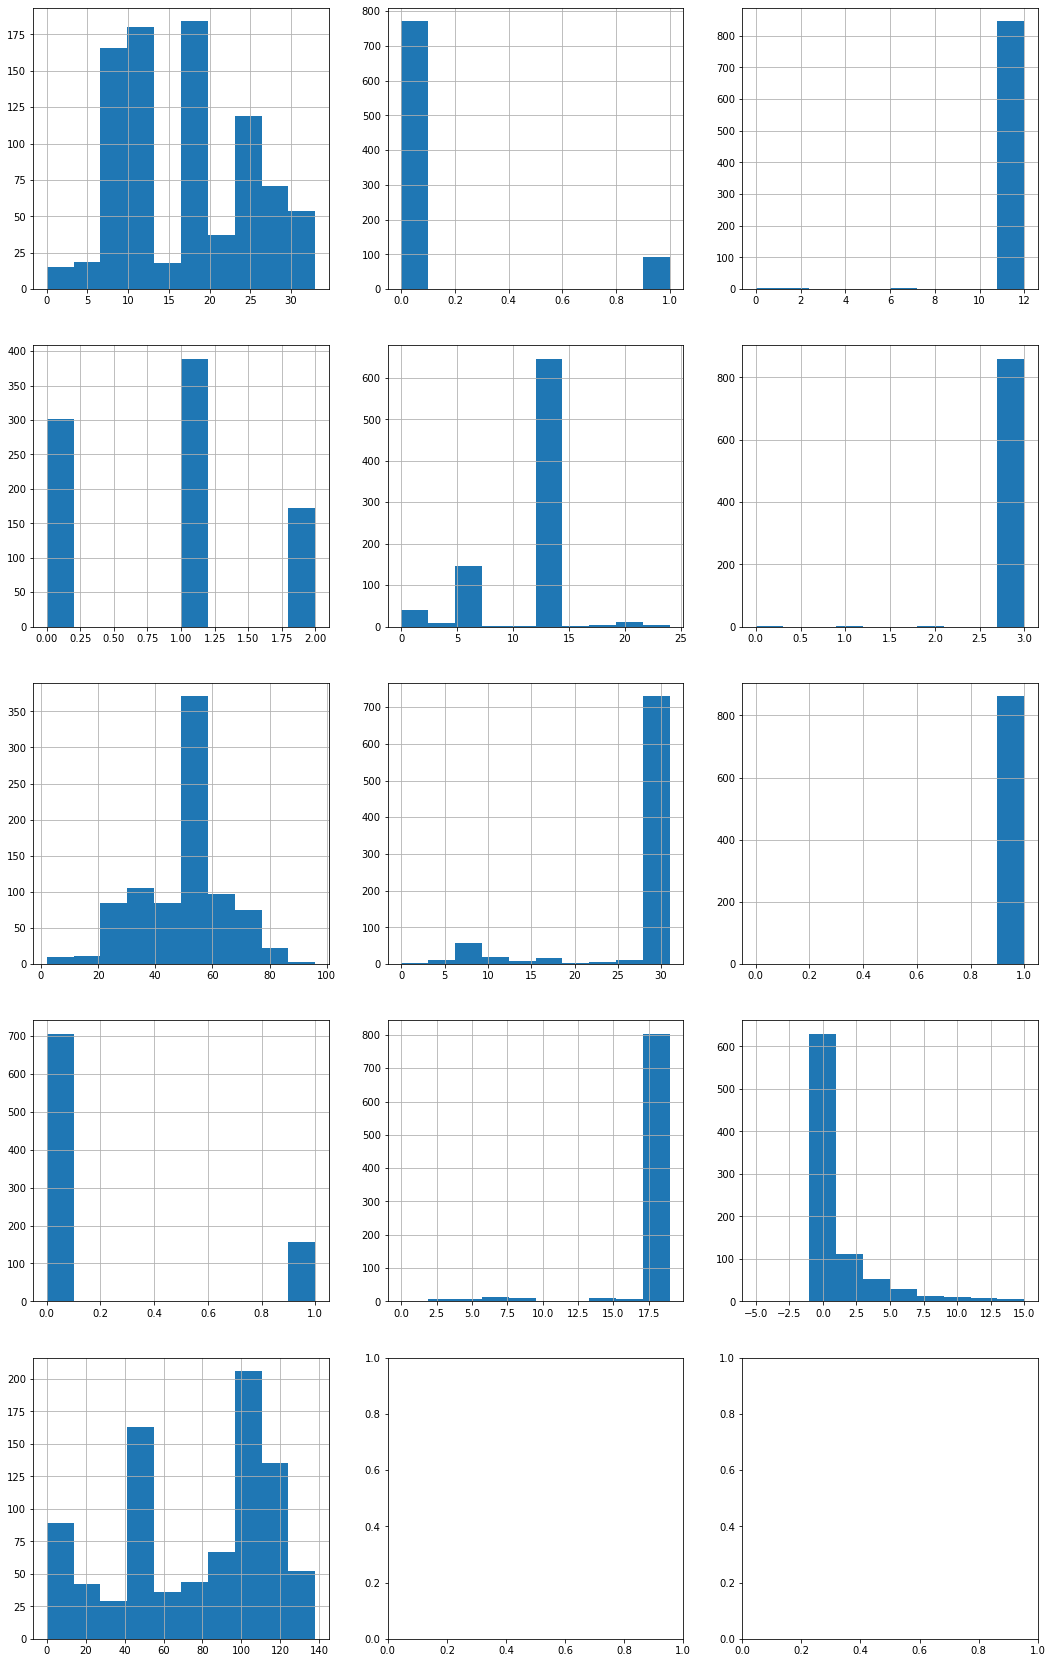

In [3]:
fig, axes = plt.subplots(5, 3, figsize=(18, 30))

df["country"].hist(ax=axes[0][0])
df["gender"].hist(ax=axes[1][0])
df["age"].hist(ax=axes[2][0])

df["vis_wuhan"].hist(ax=axes[3][0])
df["from_wuhan"].hist(ax=axes[0][1])
df["symptom1"].hist(ax=axes[1][1])

df["symptom2"].hist(ax=axes[2][1])
df["symptom3"].hist(ax=axes[3][1])

df["symptom4"].hist(ax=axes[0][2])
df["symptom5"].hist(ax=axes[1][2])
df["symptom6"].hist(ax=axes[2][2])
df["diff_sym_hos"].hist(ax=axes[3][2])

df["location"].hist(ax=axes[4][0])


KNN is based on distance calculation so using numeric encoding may interpret model in different way leading unexpected results, so One-Hot encoding might be the best choice in our given encoding techniques

Distance algorithms like KNN, K-means, and SVM are most affected by the range of features. This is because behind the scenes they are using distances between data points to determine their similarity.so feature saling is needed as to not put too much weight on one feature


In [4]:

#from sklearn.preprocessing import CategoricalEncoder as ce
df = df[["location","gender","age","country","symptom1", "symptom2", 
         "symptom3","symptom4","symptom5", "symptom6","diff_sym_hos", "result"]]

import category_encoders as ce
# encode remaining variables with one-hot encoding

encoder = ce.OneHotEncoder(cols=['country', 'location'])
df = encoder.fit_transform(df)

#normalized_df=(df-df.mean())/df.std()

from sklearn.preprocessing import  StandardScaler
#scaler =  StandardScaler()
#scaler.fit_transform(df)
df=(df-df.min())/(df.max()-df.min())
df

,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,location_10,...,country_33,country_34,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.65,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.90,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,1.0
859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,0.0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,0.0
861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,0.0


In [5]:
#### One hot encoding for country and location features only to prevent higher weights from affecting the results

#### We made one hot encoding for features with high variations as location and country to prevent some classes from having higher weights than others. For example, country with value 30 does not have greater probability than country with value 25.

In [6]:
df.info

<bound method DataFrame.info of      location_1  location_2  location_3  location_4  location_5  location_6  \
0           1.0         0.0         0.0         0.0         0.0         0.0   
1           0.0         1.0         0.0         0.0         0.0         0.0   
2           0.0         0.0         1.0         0.0         0.0         0.0   
3           0.0         0.0         0.0         1.0         0.0         0.0   
4           0.0         0.0         0.0         1.0         0.0         0.0   
..          ...         ...         ...         ...         ...         ...   
858         0.0         0.0         0.0         0.0         0.0         0.0   
859         0.0         0.0         0.0         0.0         0.0         0.0   
860         0.0         0.0         0.0         0.0         0.0         0.0   
861         0.0         0.0         0.0         0.0         0.0         0.0   
862         0.0         0.0         0.0         0.0         0.0         0.0   

     location_7  lo

<AxesSubplot:>

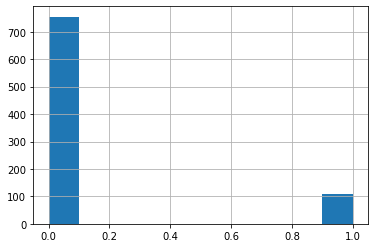

In [7]:
#Univariate analysis target.
df["result"].hist()

In [8]:
class KNN:
    def __init__(self, K):
        self.K = K
        self.X_train = None
        self.y_train = None
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict_instance(self, test_instance):
        inputs = self.X_train.copy()
        # calculate L2 norm between all training points and given test_point
        inputs['distance'] = np.linalg.norm(inputs.values-test_instance.values, axis=1)
        
        # concatenate inputs and labels before sorting the distances
        inputs = pd.concat([inputs, self.y_train], axis=1)

        # sort based on distance
        inputs = inputs.sort_values('distance', ascending=True)

        # pick k neighbors
        neighbors = inputs.head(self.K)

        # get list from dataframe column
        classes = neighbors['result'].tolist()

        # create counter of labels
        majority_count = Counter(classes)
        
        return majority_count.most_common(1).pop()[0]
        
        
    def predict(self, X_test):
        predictions = np.zeros(X_test.shape[0])
        # we want out index to be start from 0
        X_test.reset_index(drop=True, inplace=True)
        for index, row in X_test.iterrows():
            predictions[index] = self.predict_instance(row)
        return predictions

def cross_validation(n, k, data, n_neighbors):
    """
    n : # iterations
    k : k-fold size
    data: training data
    n_neighbors: k in knn
    """
    accuracies1 = []
    
    for _ in range(0, n):
        # data shuffle
        data.sample(frac=1)
        
        fold=int(data.shape[0]/k)
        
        for j in range(k):
            test = data[j*fold:j*fold+fold]
            train = data[~data.index.isin(test.index)]

            y_train= train["result"]
            
            X_train= train.drop(columns = ['result']).copy()
            y_test =test["result"]
            X_test= test.drop(columns = ["result"]).copy()
            
            knn = KNN(n_neighbors)
            knn.fit(X_train, y_train)
            
            predictions = knn.predict(X_test)
            true_values = y_test.to_numpy()
            accuracy = np.mean(predictions == true_values)
            
            accuracies1.append(accuracy)
    return np.array(accuracies1).mean()
# We will be using following settings for all the cases below
k_values = np.arange(1, 16)
cross_validation_fold = 10
accuracies = []
print(k_values)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [9]:
train,test = train_test_split(df, test_size=0.1, random_state=3)

for k in k_values:
    # run cross-validation with given neighbor size k
    accuracy = cross_validation(1, cross_validation_fold, train, k)
    accuracies.append(accuracy)


[0.9064935064935066, 0.9064935064935066, 0.8987012987012987, 0.9064935064935066, 0.9, 0.8974025974025975, 0.8987012987012987, 0.9, 0.887012987012987, 0.8922077922077923, 0.8844155844155844, 0.8831168831168832, 0.8831168831168832, 0.8870129870129869, 0.8818181818181818]


Text(0.5, 0.98, 'kNN hyperparameter (k) tuning with python alone')

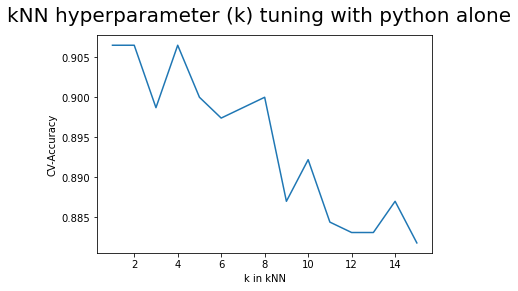

In [10]:
print(accuracies)
fig = plt.figure()
plt.plot(k_values, accuracies)
plt.xlabel('k in kNN')
plt.ylabel('CV-Accuracy')
fig.suptitle('kNN hyperparameter (k) tuning with python alone', fontsize=20)

In [11]:
#as seen above 1 and 2  have the best accuracy so we chose 1
y_test =test["result"]
X_test= test.drop(columns = ["result"]).copy()

y_train= train["result"]
X_train= train.drop(columns = ['result']).copy()
   
knn = KNN(1)
knn.fit(X_train, y_train)
            
Y_pred = knn.predict(X_test)
true_values = y_test.to_numpy()



f-1 score: 0.7058823529411765
precision_score: 0.6666666666666666
recall_score: 0.75
roc_auc_score: 0.8560126582278481


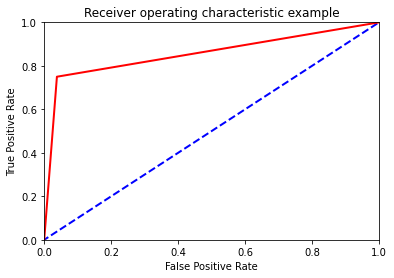

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,roc_curve,roc_auc_score,f1_score

print('f-1 score:',f1_score(y_test, Y_pred))
print('precision_score:',precision_score(y_test, Y_pred))
print('recall_score:',recall_score(y_test, Y_pred))
print('roc_auc_score:',roc_auc_score(y_test, Y_pred))
fpr, tpr, thresholds = roc_curve(y_test, Y_pred)
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2])
plt.plot(thresholds, thresholds, color="blue", lw=lw, linestyle="dashed")

plt.plot(fpr, tpr, color="red", lw=lw, linestyle="solid")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.show()


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
y=df["result"]
X= df.drop(columns = ["result"]).copy()
            
accuracies = []
for k in k_values:
    # instantiate kNN with given neighbor size k
    knn = KNeighborsClassifier(n_neighbors=k)
    # run cross validation for a given kNN setup
    # I have setup n_jobs=-1 to use all cpus in my env.
    scores = cross_val_score(knn, X, y, cv=cross_validation_fold, scoring='accuracy', n_jobs=-1)
    accuracies.append(scores.mean())
print(accuracies)

[0.7971264367816091, 0.850414327719861, 0.8224538893344026, 0.8399759422614274, 0.8271585137663726, 0.8353114140604119, 0.8283346698743653, 0.8725340817963113, 0.8516038492381716, 0.8585805934242183, 0.8434509489441326, 0.8411387329591019, 0.838799786153435, 0.8446271050521252, 0.8364875701684042]


Text(0.5, 0.98, 'kNN hyperparameter (k) tuning with sklearn')

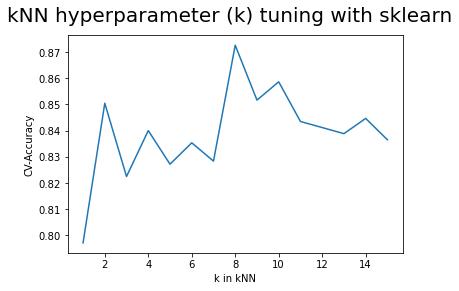

In [14]:
fig2 = plt.figure()
plt.plot(k_values, accuracies)
plt.xlabel('k in kNN')
plt.ylabel('CV-Accuracy')
fig2.suptitle('kNN hyperparameter (k) tuning with sklearn', fontsize=20)

The graph shows the best k is 8 that gives the best accuracy

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3)
from sklearn.model_selection import GridSearchCV
KNN_KFold=KFold(n_splits=10,shuffle=True,random_state=3)
neighbors = np.arange(1, 16)
param_grid  = dict(n_neighbors=neighbors)
print(param_grid)
# here 10-fold cross-validation is being executed for all the combinations
# total combinations will be : 15*2 = 30
# so in total 30 10-fold cross validatin will be run
knn = KNeighborsClassifier()
# when refit=True, it will fits the best hyperparameters to all training data
# and also allow to use GridSearchCV object as an estimator for prediction
grid_search = GridSearchCV(knn, param_grid, cv=KNN_KFold, scoring='accuracy', refit=True)
grid_search.fit(X_train, y_train)
# since refit=True,we can directly use grid_search object above as our final best model or you can do as follow:
optimal_knn = grid_search.best_estimator_
optimal_knn

{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])}


KNeighborsClassifier(n_neighbors=3)

In [16]:
cross_val_df = pd.DataFrame(grid_search.cv_results_)
cross_val_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004183,0.003973,0.005517,0.004790,1,{'n_neighbors': 1},0.948718,0.897436,0.871795,0.897436,0.820513,0.923077,0.883117,0.987013,0.883117,0.922078,0.903430,0.043063,2
1,0.003530,0.003215,0.010691,0.020903,2,{'n_neighbors': 2},0.897436,0.935897,0.910256,0.910256,0.833333,0.897436,0.870130,0.974026,0.896104,0.909091,0.903397,0.035087,3
2,0.005274,0.003961,0.003868,0.003783,3,{'n_neighbors': 3},0.897436,0.923077,0.884615,0.923077,0.820513,0.923077,0.870130,0.987013,0.896104,0.922078,0.904712,0.041113,1
3,0.002856,0.003987,0.006196,0.004349,4,{'n_neighbors': 4},0.871795,0.948718,0.871795,0.897436,0.820513,0.897436,0.857143,0.974026,0.896104,0.922078,0.895704,0.042344,6
4,0.003275,0.004186,0.004900,0.004574,5,{'n_neighbors': 5},0.884615,0.948718,0.871795,0.897436,0.846154,0.923077,0.883117,0.961039,0.922078,0.883117,0.902115,0.034033,4


In [17]:
# since for both metric (manhatton/euclidean), we will have test score
# let's use euclidean for this case
accuracies = cross_val_df["mean_test_score"]
accuracies

0     0.903430
1     0.903397
2     0.904712
3     0.895704
4     0.902115
5     0.893090
6     0.896970
7     0.889261
8     0.894406
9     0.885415
10    0.886713
11    0.882867
12    0.881568
13    0.880253
14    0.882834
Name: mean_test_score, dtype: float64

<Figure size 432x288 with 0 Axes>

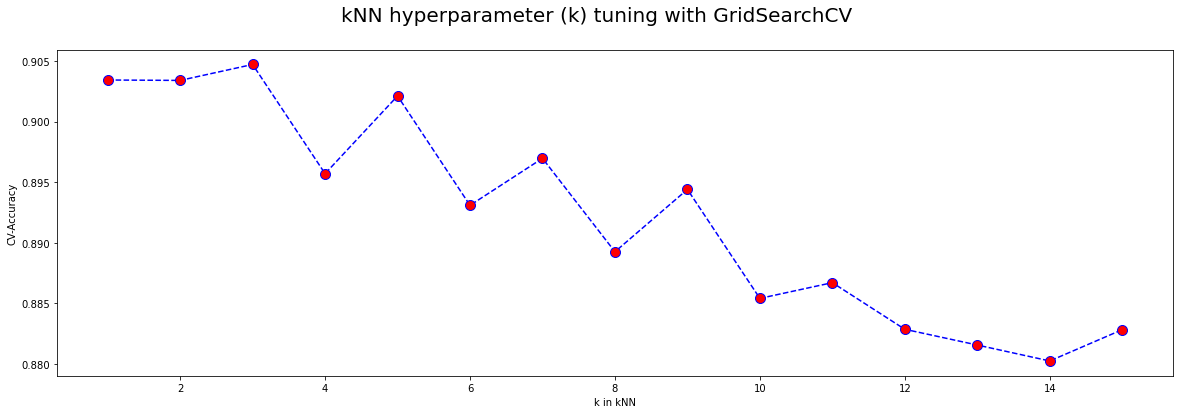

<Figure size 432x288 with 0 Axes>

In [18]:
fig3 = plt.figure(figsize=(20,6))
plt.plot(k_values, accuracies,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.xlabel('k in kNN')
plt.ylabel('CV-Accuracy')
fig3.suptitle('kNN hyperparameter (k) tuning with GridSearchCV', fontsize=20)

plt.figure()



The graph shows the best K with highest accuracy is 3 using GridSearch as shown above

In [19]:
# TESTING PHASE
# accuracy on test data
Y_pred=optimal_knn.predict(X_test)
Y_pred_proba=optimal_knn.predict_proba(X_test)
optimal_knn.score(X_test, y_test)



0.9425287356321839

f-1 score: 0.7058823529411765
precision_score: 0.6666666666666666
recall_score: 0.75
roc_auc_score: 0.9723101265822784


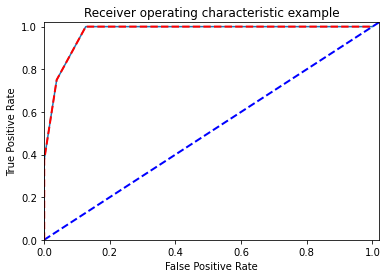

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,roc_curve,roc_auc_score,f1_score

print('f-1 score:',f1_score(y_test, Y_pred))
print('precision_score:',precision_score(y_test, Y_pred))
print('recall_score:',recall_score(y_test, Y_pred))
print('roc_auc_score:',roc_auc_score(y_test, Y_pred_proba[:,1]))
fpr, tpr, thresholds = roc_curve(y_test, Y_pred_proba[:,1])

plt.figure()
lw = 2
plt.plot(fpr, tpr)
plt.plot(thresholds, thresholds, color="blue", lw=lw, linestyle="dashed")

plt.plot(fpr, tpr, color="red", lw=lw, linestyle="dashed")
plt.xlim([0.0, 1.02])
plt.ylim([0.0, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.show()



In [21]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97        79
         1.0       0.67      0.75      0.71         8

    accuracy                           0.94        87
   macro avg       0.82      0.86      0.84        87
weighted avg       0.95      0.94      0.94        87



# Logistic regression

In [22]:
df

,location_1,location_2,location_3,location_4,location_5,location_6,location_7,location_8,location_9,location_10,...,country_33,country_34,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.65,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.90,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,1.0
859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,0.0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,0.0
861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.583333,1.0,1.0,1.0,1.0,1.0,0.25,0.0


#### One hot encoding for country and location features only was done above to prevent their variances from affecting the results

In [23]:
#Split dataset into training 80% and testing 20%
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 42, shuffle = True)

In [24]:
#Further split of training data into training data 75% with validation 10% and the testing became 15%
X_train, X_validate = train_test_split(X_train, test_size = 0.05,random_state = 42,shuffle = True)
Y_train, Y_validate = train_test_split(Y_train, test_size = 0.05,random_state = 42,shuffle = True)


In [25]:

class LogReg:
    def __init__(self, learning_rate = 0.005, iterations_no=100, cv_accuracy=0.9):
        self.lr = learning_rate
        self.iterations_no = iterations_no
        self.cv_accuracy = cv_accuracy
        self.weights = None
        self.bias = None 
        
    def fit(self, X, y):
        #features_no takes the number of attributes and samples_no is the number of rows "m" in dataset
        samples_no, features_no = X.shape    
        
        # initialize parameters with zeros
        self.weights = np.zeros(features_no)
        self.bias = 0

        # gradient descent
        for _ in range(self.iterations_no):
            # approximate y with linear combination of weights and x, plus bias
            linear_model = np.dot(X, self.weights) + self.bias
            # apply sigmoid function on our model
            y_predicted = self.sigmoid(linear_model)

            # compute gradients
            dw = (1 / samples_no) * np.dot(X.T, (y_predicted - y))
            db = (1 / samples_no) * np.sum(y_predicted - y)
            # update parameters
            self.weights = self.weights - (self.lr * dw)
            self.bias = self.bias - (self.lr * db)

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        predictions = list()
        for i in y_predicted:
            if (i > 0.5):
                predictions.append(1)
            else:
                predictions.append(0)
        return np.array(predictions)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))



In [26]:
#score accuracy of the test pedictions
#add all the labels where Y_test = Y_pred and divide them by count of Y_test to get accuracy of predictions
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true) 
    return accuracy

In [27]:
#choose the best learning rate that gives the most accurate model
def calculate_lr():
    learning_rates = [0.001, 0.01,0.05, 0.1, 0.15,0.5]
    for i in learning_rates:
        model = LogReg(learning_rate = i, iterations_no= 1000, cv_accuracy = 0.97101449)
        model.fit(X_train,Y_train)
        Y_pred = model.predict(X_test)
        print("learning rate: ",i, "--> Logistic Regression classification accuracy:", accuracy(Y_test, Y_pred))

calculate_lr()

learning rate:  0.001 --> Logistic Regression classification accuracy: 0.8554913294797688
learning rate:  0.01 --> Logistic Regression classification accuracy: 0.8554913294797688
learning rate:  0.05 --> Logistic Regression classification accuracy: 0.8554913294797688
learning rate:  0.1 --> Logistic Regression classification accuracy: 0.8728323699421965
learning rate:  0.15 --> Logistic Regression classification accuracy: 0.8901734104046243
learning rate:  0.5 --> Logistic Regression classification accuracy: 0.9132947976878613


In [28]:
model = LogReg(learning_rate = 0.5, iterations_no = 1000)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)


In [29]:
#Cross validation function that uses 10 KFolds to observe the best model
def cross_validation(n, k, data):
    accuracies = []
    for _ in range(0, n):
        # data shuffle
        data.sample(frac=1)
        fold=int(data.shape[0]/k)
        for j in range(k):
            test = data[j*fold:j*fold+fold]
            train = data[~data.index.isin(test.index)]
            X_test = test.iloc[:,:-1].values     
            Y_test = test.iloc[:,-1].values
            predictions= model.predict(X_test)
            true_values = Y_test
            accuracy = np.mean(predictions == true_values)
            accuracies.append(accuracy)
    return np.array(accuracies)
# We will be using following settings for all the cases below cross_validation_fold = 10
cross_validation_fold = 10

In [30]:
train, test = train_test_split(df, test_size=.2, random_state = 42, shuffle = True)
accuracies=[]
accuracy = cross_validation(1, cross_validation_fold, train)
accuracies.append(accuracy)

print("accuracies of the best fold:",accuracy)
kFold_values = np.arange(0, 10)
print(kFold_values)

accuracies of the best fold: [0.94202899 0.98550725 0.92753623 0.94202899 0.92753623 0.89855072
 0.92753623 0.95652174 0.88405797 0.97101449]
[0 1 2 3 4 5 6 7 8 9]


Text(0.5, 0.98, 'Logistic Regression hyperparameter (kFold) tuning with cross validation')

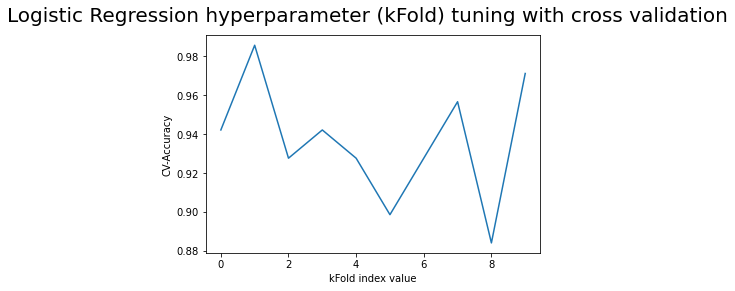

In [31]:
fig = plt.figure()
plt.plot(range(10), accuracy)
plt.xlabel('kFold index value')
plt.ylabel('CV-Accuracy')
fig.suptitle('Logistic Regression hyperparameter (kFold) tuning with cross validation', fontsize=20)

We conclude from the plot that the best fold is index 1 of accuracy 0.98550725

In [32]:
#score accuracy of the test pedictions
#add all the labels where Y_test = Y_pred and divide them by count of Y_test to get accuracy of predictions
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true) 
    return accuracy

print("LogReg classification accuracy: ", accuracy(Y_test, Y_pred))


LogReg classification accuracy:  0.9132947976878613


In [33]:
def get_conf_matrix(y_true, y_pred):
    n_classes = len(np.unique(y_true))        #count number of classes in target values (0, 1) to create a 2D array
    conf = np.zeros((n_classes, n_classes))   #create a 2D array initialized with zeros
    for actual, pred in zip(y_true, y_pred):  #loop through all Y_test values and predictions to count confusion matrix elements
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

print('Confusion Matrix: ', get_conf_matrix(Y_test, Y_pred))

Confusion Matrix:  [[146   2]
 [ 13  12]]


From Confusion Matrix we conclude that:
True negative: 146 /
True positive: 13 /
False Negative: 12 / 
False Positive: 2

From our confusion matrix True negative>> True positive as it our positive result is 1 while 1 results are fewer than 0 

In [34]:
print('precision score: %.3f' % precision_score(Y_test,Y_pred))

precision score: 0.857


In [35]:
print('recall score: %.3f' % recall_score( Y_test, Y_pred))

recall score: 0.480


In [36]:
print('F1- score: %.3f' % f1_score(Y_test,Y_pred))

F1- score: 0.615


In [37]:
fpr, tpr, thresholds = roc_curve(Y_test,Y_pred)
auc = roc_auc_score(Y_test, Y_pred)
print (auc)

0.7332432432432432


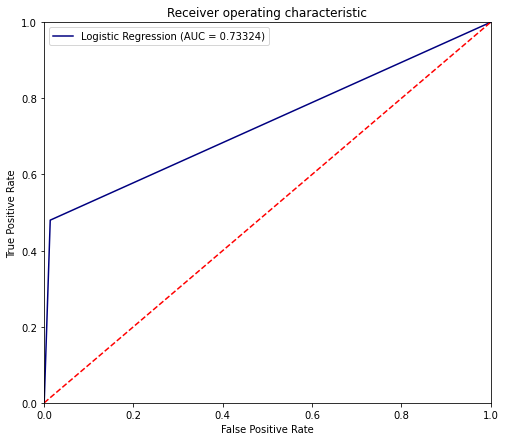

In [38]:
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, color="navy", linestyle="solid", label = 'Logistic Regression (AUC = %0.5f)' % auc)
plt.plot( [0, 1.0], [0, 1.0], color="red", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend()
plt.show()

# The following is another logistic regression model using sklearn


In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

In [40]:
model2 = LogisticRegression()
model2.fit(X_train, Y_train)

LogisticRegression()

In [41]:
#Tuning hyperparameters to choose the most accurate ones
grid = dict(solver=['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], 
            penalty= ['l2','l1', 'elasticnet'], C=[10, 0.1, 0.01, 0.5])

CV = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

hyper_search = GridSearchCV(estimator = model2, param_grid = grid, n_jobs=-1, cv= CV, scoring='accuracy',error_score=0)

hyperparameter = hyper_search.fit(X_train, Y_train)


In [42]:
# Print the most fitting hyperparameters
print("Best score: %f using %s" % (hyperparameter.best_score_, hyperparameter.best_params_))


Best score: 0.957761 using {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}


In [43]:
#Print all hyperparameters checked
means = hyperparameter.cv_results_['mean_test_score']
stds = hyperparameter.cv_results_['std_test_score']
parameters = hyperparameter.cv_results_['params']
for i, j, k in zip(means, stds, parameters):
    print("%f (%f) with: %r" % (i, j, k))

0.909924 (0.024806) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.955216 (0.014976) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.955216 (0.014976) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.915522 (0.029296) with: {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.913486 (0.025190) with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.955216 (0.014714) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l1', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'l1', 'solver': 'sag'}
0.921628 (0.021853) with: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'elasticnet', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 10, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) wi

In [44]:
model2 = LogisticRegression(solver='liblinear', C = 0.5, penalty = 'l1', random_state= 42)
model2.fit(X_train, Y_train)

LogisticRegression(C=0.5, penalty='l1', random_state=42, solver='liblinear')

In [45]:
Y_proba = model2.predict_proba(X_test)[::,1]
Y_pred = model2.predict(X_test)
score = model2.score(X_test, Y_test)

In [46]:
print( classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       148
         1.0       0.81      0.68      0.74        25

    accuracy                           0.93       173
   macro avg       0.88      0.83      0.85       173
weighted avg       0.93      0.93      0.93       173



In [47]:
confusion_matrix(Y_test, Y_pred)

array([[144,   4],
       [  8,  17]], dtype=int64)

In [48]:
print("accuracy score: ",score)

accuracy score:  0.930635838150289


In [49]:
print('Precision: %.3f' % precision_score(Y_test, Y_pred))

Precision: 0.810


In [50]:
print('Recall: %.3f' % recall_score(Y_test, Y_pred))

Recall: 0.680


In [51]:
print('F1 score: %.3f' % f1_score(Y_test, Y_pred))

F1 score: 0.739


In [52]:
fpr, tpr, thresholds = roc_curve(Y_test,Y_proba)

In [53]:
auc = roc_auc_score(Y_test, Y_proba)
print (auc)

0.92


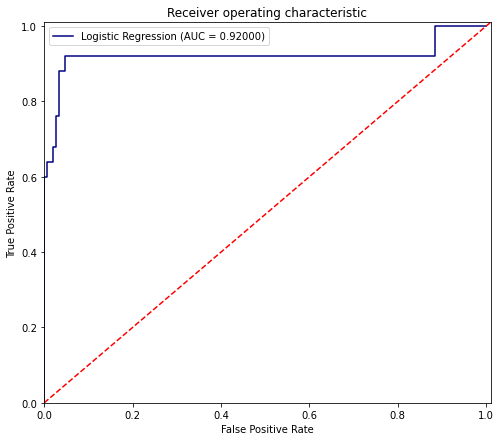

In [54]:
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, color="navy", linestyle="solid", label = 'Logistic Regression (AUC = %0.5f)' % auc)
plt.plot( [0, 1.01], [0, 1.01], color="red", linestyle="--")
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend()
plt.show()

### The ROC curve of the liner regression model is better with higher area under the curve than the implemented graph

# Naive bayes

In [55]:
#Reading Dataset
df = pd.read_csv('data.csv',index_col = 0)  
df = df.iloc[: , 0:]
df = df[["location","country","gender","age","vis_wuhan","symptom5","symptom6","from_wuhan","diff_sym_hos", "result"]]
Y = df['result']
X = df.drop(columns = ['result']).copy()
X

,location,country,gender,age,vis_wuhan,symptom5,symptom6,from_wuhan,diff_sym_hos
0,104,8,1,66.0,1,3,1,0,8
1,101,8,0,56.0,0,3,1,1,0
2,137,8,1,46.0,0,3,1,1,13
3,116,8,0,60.0,1,3,1,0,0
4,116,8,1,58.0,0,3,1,0,0
...,...,...,...,...,...,...,...,...,...
858,48,3,2,24.0,0,3,1,0,0
859,0,0,2,35.0,0,3,1,0,0
860,3,1,1,49.4,0,3,1,0,0
861,24,9,1,49.4,0,3,1,0,0


We made some feature scaling to produce the best model with highest accuracy

<AxesSubplot:>

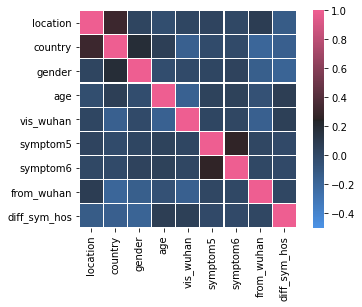

In [56]:
corr = df.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

### This plot shows the covariance between each feature and all other features, as we assume in Naive Bayes that they are all independent so we need to make sure that there is no covariance between any features

In [57]:
X_train,X_test, Y_train ,Y_test = train_test_split(X, Y, test_size=.2,shuffle = True, random_state= 3)


In [58]:
NaiveKFold = KFold(n_splits = 10, shuffle = True, random_state = 3)
naiveModel = GaussianNB()
hyperparameters= {'var_smoothing':[1e-05, 1e-08,1e-07,1e-06]}
bestModel = GridSearchCV(naiveModel, hyperparameters, cv = NaiveKFold)
bestModel.fit(X_train, Y_train)

print(bestModel.best_params_)
print(bestModel.best_score_)

bestVarSmoothing = bestModel.best_params_.get('var_smoothing')
print(bestVarSmoothing)
results = cross_val_score(GaussianNB(var_smoothing = bestVarSmoothing), X_train, Y_train, cv = 15)
print(results)
print("The accuracy is: ", results.mean()*100)

{'var_smoothing': 1e-05}
0.927536231884058
1e-05
[0.95652174 0.95652174 0.97826087 0.89130435 0.84782609 0.91304348
 0.95652174 0.84782609 0.95652174 0.93478261 0.89130435 0.89130435
 0.97826087 0.86956522 0.86956522]
The accuracy is:  91.59420289855072


In [59]:
naiveModel = GaussianNB(var_smoothing = bestVarSmoothing)
naiveModel.fit(X_train, Y_train)

GaussianNB(var_smoothing=1e-05)

Create a new model using skLearn

In [60]:
Y_proba = naiveModel.predict_proba(X_test)
Y_pred = naiveModel.predict(X_test)
score = naiveModel.score(X_test, Y_test)


In [61]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       155
           1       0.59      0.72      0.65        18

    accuracy                           0.92       173
   macro avg       0.78      0.83      0.80       173
weighted avg       0.93      0.92      0.92       173



In [62]:
print("accuracy score: ",score)

accuracy score:  0.9190751445086706


In [63]:
print('Recall: %.3f' % recall_score(Y_test, Y_pred))

Recall: 0.722


In [64]:
print('F1 score: ', f1_score(Y_test, Y_pred))

F1 score:  0.65


In [65]:
confusion_matrix(Y_test, Y_pred)

array([[146,   9],
       [  5,  13]], dtype=int64)

In [66]:
fpr, tpr, thresholds = roc_curve(Y_test,Y_proba[:,1])

In [67]:
auc = roc_auc_score(Y_test, Y_proba[:,1])
print (auc)

0.8763440860215054


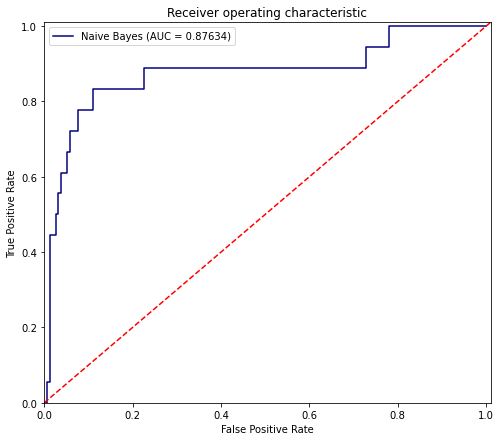

In [68]:
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, color="navy", linestyle="solid", label = 'Naive Bayes (AUC = %0.5f)' % auc)
plt.plot( [0, 1.01], [0, 1.01], color="red", linestyle="--")
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend()
plt.show()

# naive bayes implementation

In [69]:
#Reading Dataset
df = pd.read_csv('data.csv',index_col = 0)  
df = df.iloc[: , 0:]
df = df[["location","gender","age","country","symptom1", "symptom2", "symptom3","symptom4",
         "vis_wuhan","from_wuhan","diff_sym_hos", "result"]]
Y = df['result']
X = df.drop(columns = ['result']).copy()
X

,location,gender,age,country,symptom1,symptom2,symptom3,symptom4,vis_wuhan,from_wuhan,diff_sym_hos
0,104,1,66.0,8,14,31,19,12,1,0,8
1,101,0,56.0,8,14,31,19,12,0,1,0
2,137,1,46.0,8,14,31,19,12,0,1,13
3,116,0,60.0,8,14,31,19,12,1,0,0
4,116,1,58.0,8,14,31,19,12,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
858,48,2,24.0,3,14,31,19,12,0,0,0
859,0,2,35.0,0,14,31,19,12,0,0,0
860,3,1,49.4,1,14,31,19,12,0,0,0
861,24,1,49.4,9,14,31,19,12,0,0,0


<AxesSubplot:>

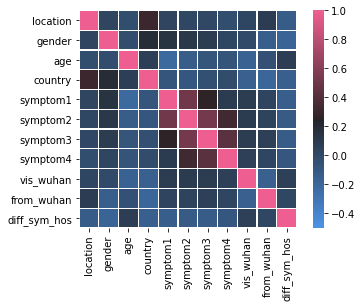

In [70]:
corr = df.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [71]:
### This plot shows the covariance between each feature and all other features, as we assume in Naive Bayes that they are all independent so we need to make sure that there is no covariance between any features

In [72]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

In [73]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

In [74]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

In [75]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=3)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X = X_test, Y="result")
print(confusion_matrix(Y_test, Y_pred))
print("f1-score: ",f1_score(Y_test, Y_pred))
print("recall score: ",recall_score(Y_test, Y_pred))
print("precision score: ",precision_score(Y_test, Y_pred))
fpr, tpr, thresholds = roc_curve(Y_test,Y_pred)

[[143  12]
 [  7  11]]
f1-score:  0.5365853658536586
recall score:  0.6111111111111112
precision score:  0.4782608695652174


In [76]:
auc = roc_auc_score(Y_test, Y_pred)
print (auc)

0.7668458781362008


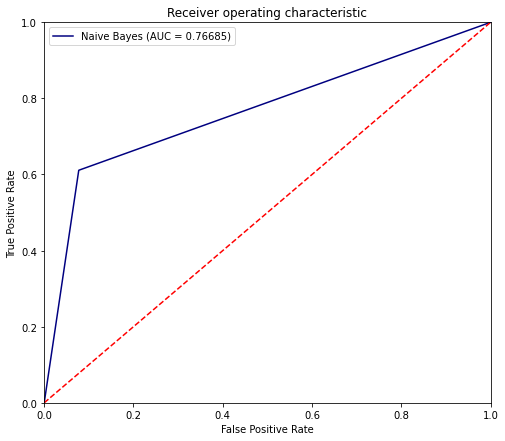

In [77]:
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, color="navy", linestyle="solid", label = 'Naive Bayes (AUC = %0.5f)' % auc)
plt.plot( [0, 1], [0, 1], color="red", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend()
plt.show()

In [78]:
### The ROC curve seems to be normal as it is above the thresholds line and the area under curve > 0.5 which means that our prediction is better than guessing 


In [79]:
"""
n : # iterations
k : k-fold size
data: training data
"""
def cross_validation(n, k, data):

    accuracies = []
    for _ in range(0, n):
    # data shuffle
        data.sample(frac=1)
        fold=int(data.shape[0]/k)
        for j in range(k):
            test = data[j*fold:j*fold+fold]
            train = data[~data.index.isin(test.index)]
            X_test = test.iloc[:,:-1].values     
            Y_test = test.iloc[:,-1].values
            predictions=naive_bayes_gaussian(train, X_test, Y="result")
            true_values = Y_test
            accuracy = np.mean(predictions == true_values)
            accuracies.append(accuracy)
    return np.array(accuracies)
# We will be using following settings for all the cases belowcross_validation_fold = 10
cross_validation_fold = 10
accuracies = []

In [80]:
train, test = train_test_split(df, test_size=.1, random_state=41)
accuracy = cross_validation(1, cross_validation_fold, train)
accuracies.append(accuracy)
KFold_values=np.arange(1,11)

In [81]:
print(accuracy)

[0.87012987 0.92207792 0.87012987 0.90909091 0.92207792 0.79220779
 0.84415584 0.84415584 0.92207792 0.92207792]


Text(0.5, 0.98, 'Naive Bayes hyperparameters tuning with cross validation')

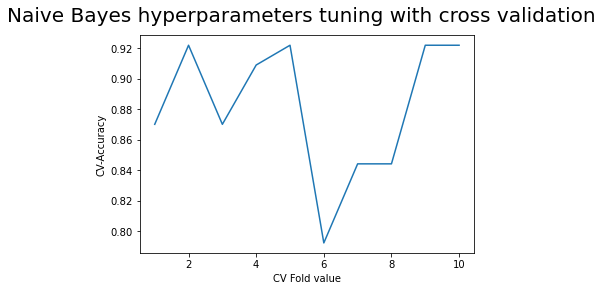

In [82]:
fig = plt.figure()
plt.plot(KFold_values, accuracy)
plt.xlabel('CV Fold value')
plt.ylabel('CV-Accuracy')
fig.suptitle('Naive Bayes hyperparameters tuning with cross validation', fontsize=20)

In [83]:
def get_conf_matrix(y_true, y_pred):
    n_classes = len(np.unique(y_true))        #count number of classes in target values (0, 1) to create a 2D array
    conf = np.zeros((n_classes, n_classes))   #create a 2D array initialized with zeros
    for actual, pred in zip(y_true, y_pred):  #loop through all Y_test values and predictions to count confusion matrix elements
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

print(get_conf_matrix(Y_test, Y_pred))

[[143  12]
 [  7  11]]


In [84]:
TN = 143
FN = 7
TP = 11
FP = 12

In [85]:
precision = TP / (TP + FP)
print('precision score: %.3f' % precision)

precision score: 0.478


In [86]:
recall = TP / (TP + FN)
print('recall score: ', recall)

recall score:  0.6111111111111112


In [87]:
f1 = TP / (TP + (FN + FP)/2)
print('f1 score: %.3f' % f1)

f1 score: 0.537


In [88]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       155
           1       0.48      0.61      0.54        18

    accuracy                           0.89       173
   macro avg       0.72      0.77      0.74       173
weighted avg       0.90      0.89      0.90       173

